# II - Mean–Variance Portfolio Optimization: A Pareto-Optimal Case Study.


Modern Portfolio Theory provides a mathematical framework for constructing investment portfolios that balance expected return against risk, where risk is measured by the variance (or standard deviation) of portfolio returns. This framework—commonly referred to as *mean–variance analysis*—was introduced by Harry Markowitz and forms the foundation of quantitative portfolio construction.

> - Mean–Variance Optimization: Select portfolio weights to trade off expected return against return variance.  
> - Efficient Frontier: The set of portfolios that achieve the maximum expected return for a given level of risk, or equivalently, the minimum risk for a given expected return.  
> - Pareto Optimality: A portfolio is Pareto-optimal if no other feasible portfolio offers higher return at the same level of risk.

In this case study, we analyze a diversified universe of liquid financial assets using publicly available historical market data.

- Assets consist of widely traded exchange-traded funds (ETFs) spanning multiple asset classes  
- Historical price data covers several years  
- Expected returns and the covariance matrix are estimated from historical returns  

### Formulation

We seek to determine portfolio weights that optimally balance expected return and risk, subject to realistic investment constraints commonly encountered in practice.


#### Objective Function

Two equivalent formulations are commonly used:

- Minimize portfolio variance for a target return:  $\min \; w^\top \Sigma w$

- Maximize risk-adjusted return:  $\max \; \mu^\top w - \lambda \, w^\top \Sigma w$

where:
- $w$ is the vector of portfolio weights  
- $\mu$ is the vector of expected asset returns  
- $\Sigma$ is the covariance matrix of asset returns  
- $\lambda > 0$ is a risk-aversion parameter  


#### Decision Variables

- $w_i$: portfolio weight allocated to asset $i$


#### Parameters

- $\mu_i$: expected return of asset $i$  
- $\Sigma_{ij}$: covariance between returns of assets $i$ and $j$  
- $\lambda$: risk-aversion coefficient  


#### Constraints

- Long-only: portfolio weights must be non-negative ($w_i \ge 0$).  
- Fully invested: portfolio weights sum to one ($\sum_i w_i = 1$).  
- Maximum per-asset allocation: $w_i \le 0.25$ to prevent excessive concentration.


This optimization problem is quadratic programming (QP) problem

- The objective function contains a quadratic term $w^\top \Sigma w$  
- The covariance matrix $\Sigma$ is positive semidefinite  
- All constraints are linear  


In [15]:
#!pip install  pandas_datareader

In [1]:
# Install and import necessary libraries
#!pip install yfinance cvxpy pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr




## Data Acquisition and Cleaning

We begin by selecting a representative universe of financial assets and obtaining their historical price data from publicly available sources. To ensure reproducibility and eliminate reliance on proprietary services or API keys, we use historical market data from [Stooq](https://www.quantstart.com/articles/an-introduction-to-stooq-pricing-data/), a freely accessible financial data repository .

The asset universe consists of liquid ETFs spanning multiple asset classes, such as U.S. equities, sector-specific equities, government bonds, and commodities. Historical daily closing prices are retrieved over a multi-year horizon to capture different market conditions and provide sufficient data for robust estimation of expected returns and risk.


In [2]:
tickers_dict = {
    # Broad Equity
    "SPY.US": "U.S. broad-market equity (S&P 500)",
    "VTI.US": "Total U.S. stock market",

    # Sector-Specific Equities
    "XLK.US": "Technology sector",
    "XLF.US": "Financials sector",
    "XLE.US": "Energy sector",
    "XLV.US": "Healthcare sector",
    "XLY.US": "Consumer Discretionary sector",
    "XLI.US": "Industrials sector",
    "XLRE.US": "Real Estate sector",

    # Size / Style
    "IWM.US": "Russell 2000 ETF",
    "QQQ.US": "NASDAQ 100 ETF (tech-heavy)",

    # International Equity
    "EFA.US": "Developed markets (ex-US)",
    "EEM.US": "Emerging markets",
    "VXUS.US": "Total International equity",

    # Government Bonds
    "IEF.US": "U.S. Treasuries 7–10Y",
    "TLT.US": "U.S. Treasuries 20+Y",
    "SHY.US": "Short-term Treasuries",

    # Corporate / High Yield
    "LQD.US": "Investment-grade corporate bonds",
    "HYG.US": "High-yield corporate bonds",

    # Commodities
    "GLD.US": "Gold",
    "SLV.US": "Silver",
    "DBC.US": "Broad commodities",
    "USO.US": "Crude Oil",
    "UNG.US": "Natural Gas",

    # Alternative / Real Assets
    "VNQ.US": "U.S. Real Estate (REITs)",
    "ICLN.US": "Global Clean Energy"

    # Cryptocurrency
    #"BTC-USD": "Bitcoin (USD-denominated)"
}
tickers = list(tickers_dict.keys())

print(len(tickers))

26


In [3]:
# Define asset tickers and download data (3 years of daily data)
start_date = "2023-01-01"
end_date = "2025-12-20"

prices = pd.DataFrame()

for ticker in tickers:
    print(f"Downloading data for {ticker}...")
    data = pdr.DataReader(ticker, "stooq", start_date, end_date)
    prices[ticker] = data["Close"]

prices = prices.sort_index()

In [4]:
print("Missing values per ticker:")
#print(prices.isna().sum())

# Drop rows with any missing values
prices = prices.dropna()

Missing values per ticker:


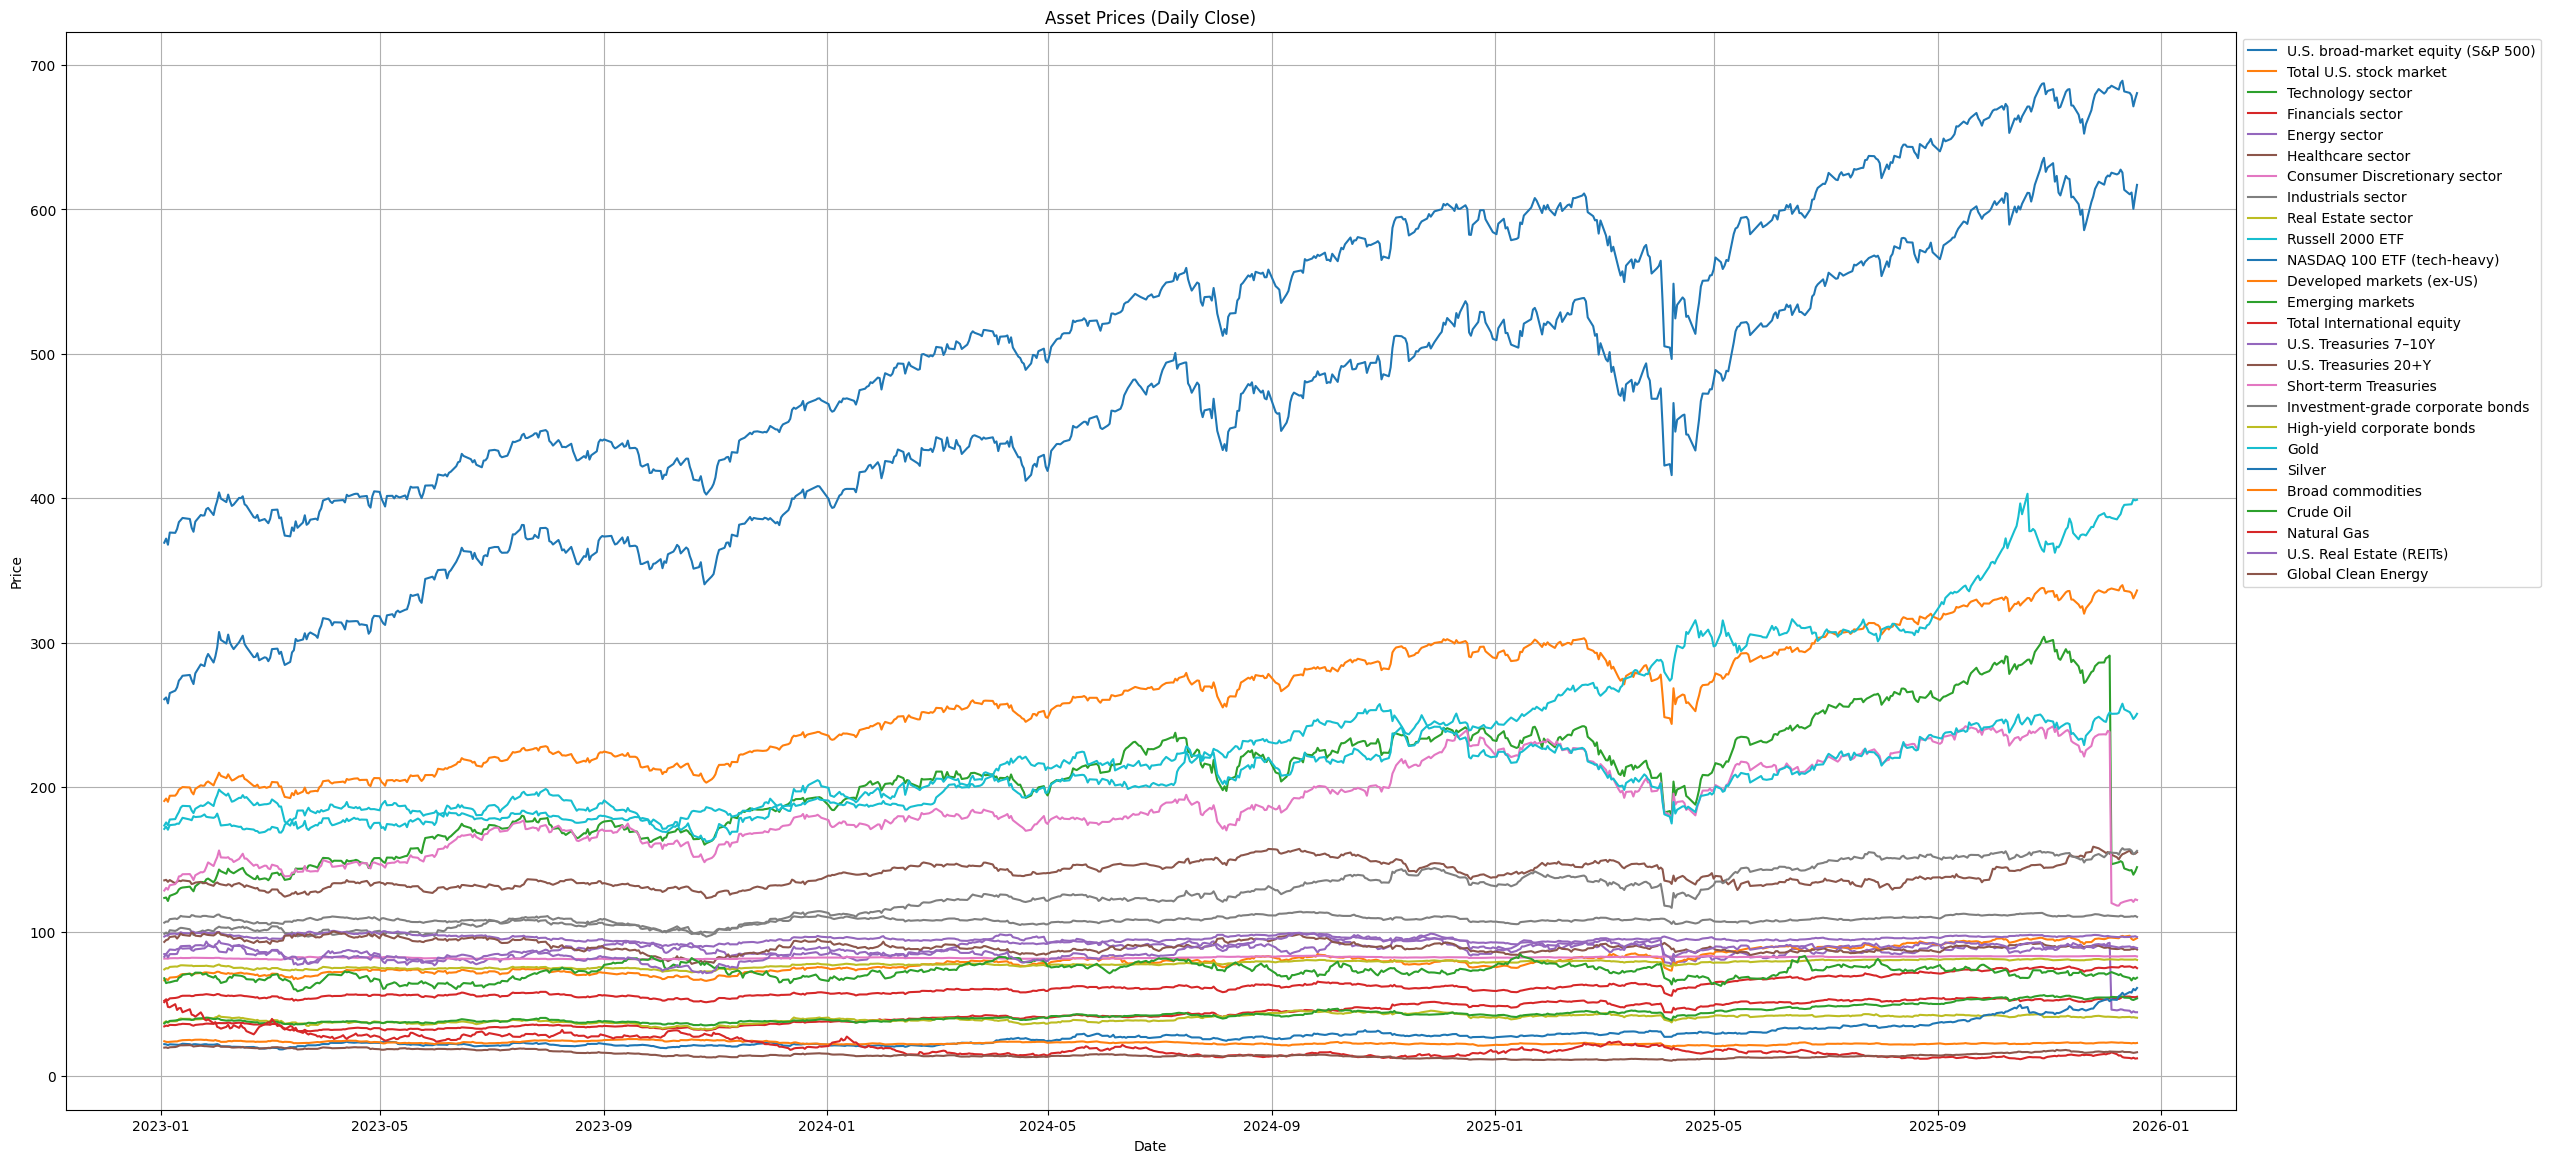

In [5]:
plt.figure(figsize=(28, 14))

for ticker in prices.columns:
    plt.plot(prices.index, prices[ticker], label=tickers_dict[ticker])

plt.title("Asset Prices (Daily Close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()


In [6]:
## Returns & Risk Estimation

# Daily returns
returns = prices.pct_change().dropna()

trading_days_per_year = len(returns) / ((returns.index[-1] - returns.index[0]).days / 365)

# Annualized statistics
mu = returns.mean() * trading_days_per_year
Sigma = returns.cov() * trading_days_per_year



# --- Weekly returns ---
weekly_returns = prices.resample('W').last().pct_change().dropna()
trading_weeks_per_year = 52  # standard
mu_weekly = weekly_returns.mean() * trading_weeks_per_year

# --- Monthly returns ---
monthly_returns = prices.resample('ME').last().pct_change().dropna()
trading_months_per_year = 12
mu_monthly = monthly_returns.mean() * trading_months_per_year

# --- Combine into DataFrame ---
mu_df = pd.DataFrame({
    'Asset': [tickers_dict[t] for t in prices.columns],
    'Annualized Daily Return': mu.values,
    'Annualized Weekly Return': mu_weekly.values,
    'Annualized Monthly Return': mu_monthly.values
})

# Sort by Annualized Daily Return descending
mu_df = mu_df.sort_values(by='Annualized Monthly Return', ascending=False).reset_index(drop=True)
mu_df


Asset  Annualized Daily Return  \
0                               Silver                 0.384067   
1                                 Gold                 0.299218   
2          NASDAQ 100 ETF (tech-heavy)                 0.311032   
3   U.S. broad-market equity (S&P 500)                 0.218446   
4              Total U.S. stock market                 0.204311   
5                   Industrials sector                 0.168020   
6                    Financials sector                 0.172198   
7                     Emerging markets                 0.145270   
8                     Russell 2000 ETF                 0.147370   
9            Developed markets (ex-US)                 0.134415   
10          Total International equity                 0.131797   
11                   Technology sector                 0.144699   
12                   Healthcare sector                 0.054585   
13          High-yield corporate bonds                 0.030829   
14                           Crude Oil                 0.045700   
15                  Real Estate sector                 0.044486   
16       Consumer Discretionary sector                 0.068886   
17               Short-term Treasuries                 0.006527   
18            U.S. Real Estate (REITs)                 0.039841   
19    Investment-grade corporate bonds                 0.015634   
20               U.S. Treasuries 7–10Y                 0.001794   
21                   Broad commodities                -0.005557   
22                U.S. Treasuries 20+Y                -0.008399   
23                 Global Clean Energy                -0.030941   
24                       Energy sector                -0.129084   
25                         Natural Gas                -0.312402   

    Annualized Weekly Return  Annualized Monthly Return  
0                   0.387958                   0.393563  
1                   0.292404                   0.286397  
2                   0.304409                   0.271663  
3                   0.210848                   0.195445  
4                   0.196916                   0.179124  
5                   0.159802                   0.157793  
6                   0.162923                   0.152073  
7                   0.128816                   0.115537  
8                   0.137934                   0.111278  
9                   0.125603                   0.105827  
10                  0.121534                   0.103827  
11                  0.137155                   0.103551  
12                  0.054160                   0.060555  
13                  0.022513                   0.018823  
14                  0.060544                   0.018543  
15                  0.036616                   0.011133  
16                  0.055095                   0.009095  
17                  0.005279                   0.004174  
18                  0.031769                   0.003941  
19                  0.007656                   0.001178  
20                 -0.004978                  -0.007952  
21                  0.000307                  -0.022092  
22                 -0.021982                  -0.029124  
23                 -0.036411                  -0.050184  
24                 -0.142963                  -0.158374  
25                 -0.285856                  -0.263702

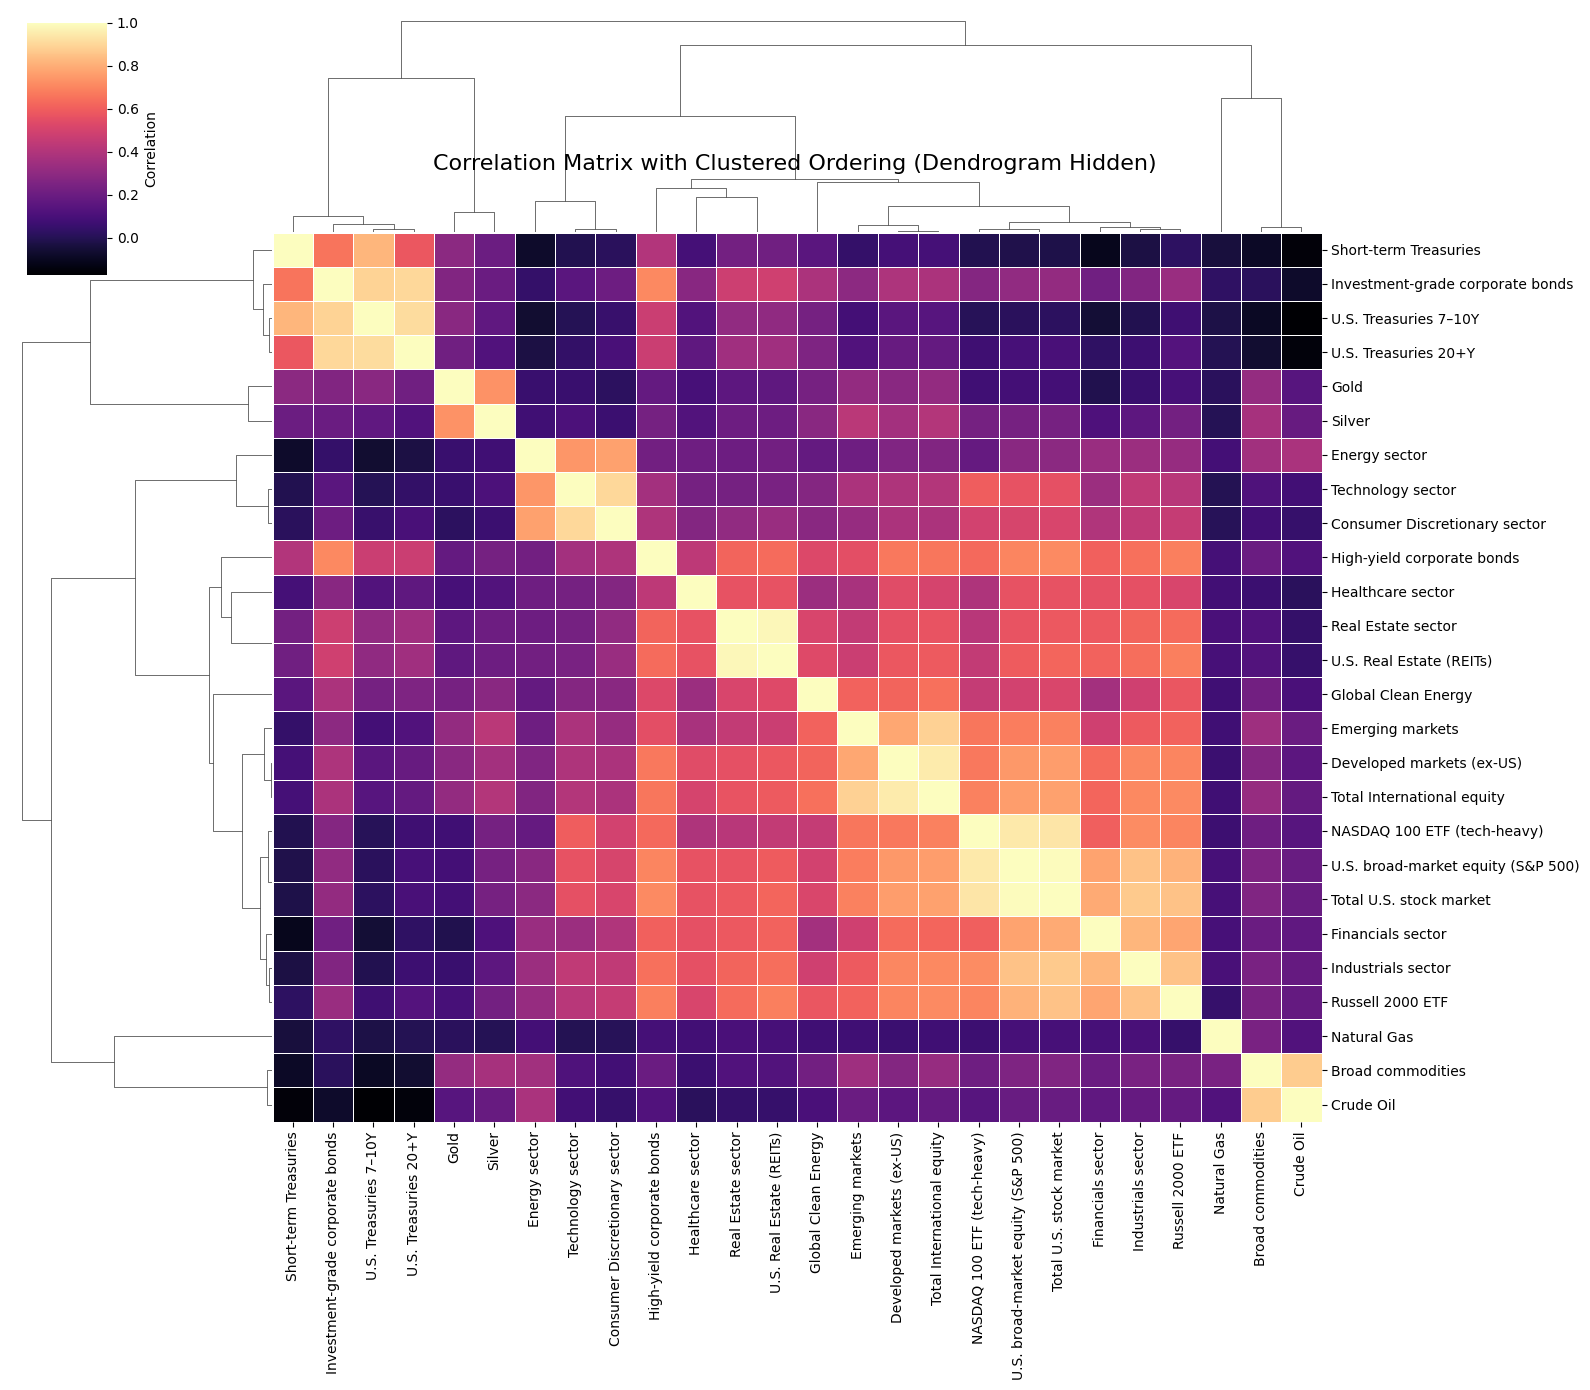

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = returns.corr()

# Rename rows and columns using full asset names
corr_named = corr.rename(index=tickers_dict, columns=tickers_dict)

g= sns.clustermap(
    corr_named,
    cmap="magma",
    figsize=(16, 14),
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    method='average',
    metric='correlation')
g.fig.text(
    0.5,                # x-position (center)
    0.875,               # y-position (near bottom)
    "Correlation Matrix with Clustered Ordering (Dendrogram Hidden)",
    ha='center',
    fontsize=16
)
plt.show()


## Mathematical Formulation

Let:

- $\mathbf{w} = [w_1, w_2, \dots, w_n]^\top$ be the portfolio weights,  
- $\mathbf{r} = [r_1, r_2, \dots, r_n]^\top$ be the expected returns,  
- $\mathbf{C}$ be the covariance matrix of asset returns.

The portfolio expected return and variance are:

$$
r_p = \mathbf{w}^\top \mathbf{r}, \qquad
\sigma_p^2 = \mathbf{w}^\top \mathbf{C} \mathbf{w}.
$$

 
### Objectives

We aim to maximize return and minimize risk simultaneously. Define:

$$
f_1(\mathbf{w}) = -\mathbf{r}^\top \mathbf{w} \quad \text{(maximize return)}, 
\qquad
f_2(\mathbf{w}) = \mathbf{w}^\top \mathbf{C} \mathbf{w} \quad \text{(minimize risk)}.
$$

A weighted scalarization of the two objectives allows us to trace the efficient frontier:

$$
\min_{\mathbf{w}} \ -\alpha \, \mathbf{r}^\top \mathbf{w} + (1-\alpha) \, \mathbf{w}^\top \mathbf{C} \mathbf{w}, 
\quad 0 \le \alpha \le 1.
$$

- $\alpha = 0$ → minimize risk only.  
- $\alpha = 1$ → maximize return only.  
- Varying $\alpha$ from 0 to 1 produces the Pareto-optimal frontier.

### Constraints

$$
\sum_{i=1}^n w_i = 1, \quad 0 \le w_i \le 0.25, \quad \forall i.
$$


By sweeping the trade-off parameter $\alpha$ in the weighted scalarization problem, we can compute a set of optimal portfolios that balance return and risk under realistic investment constraints. This approach provides both practical portfolio recommendations and a visualization of the efficient frontier, aiding investment decision-making in multi-asset portfolios.

In [8]:
## CVXPY Implementation

n = len(tickers)
w = cp.Variable(n)

# Weighted scalarization function
def solve_portfolio(alpha):
    objective = cp.Minimize(-alpha * mu.values @ w + (1 - alpha) * cp.quad_form(w, Sigma.values))
    constraints = [cp.sum(w) == 1, w >= 0, w <= 0.25]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value


In [9]:
alphas = np.linspace(0, 1, 100)
frontier_returns = []
frontier_risks = []
weights_list = []

for alpha in alphas:
    weights = solve_portfolio(alpha)
    weights_list.append(weights.round(4))
    r_p = mu.values @ weights
    sigma_p = np.sqrt(weights.T @ Sigma.values @ weights)
    frontier_returns.append(r_p)
    frontier_risks.append(sigma_p)

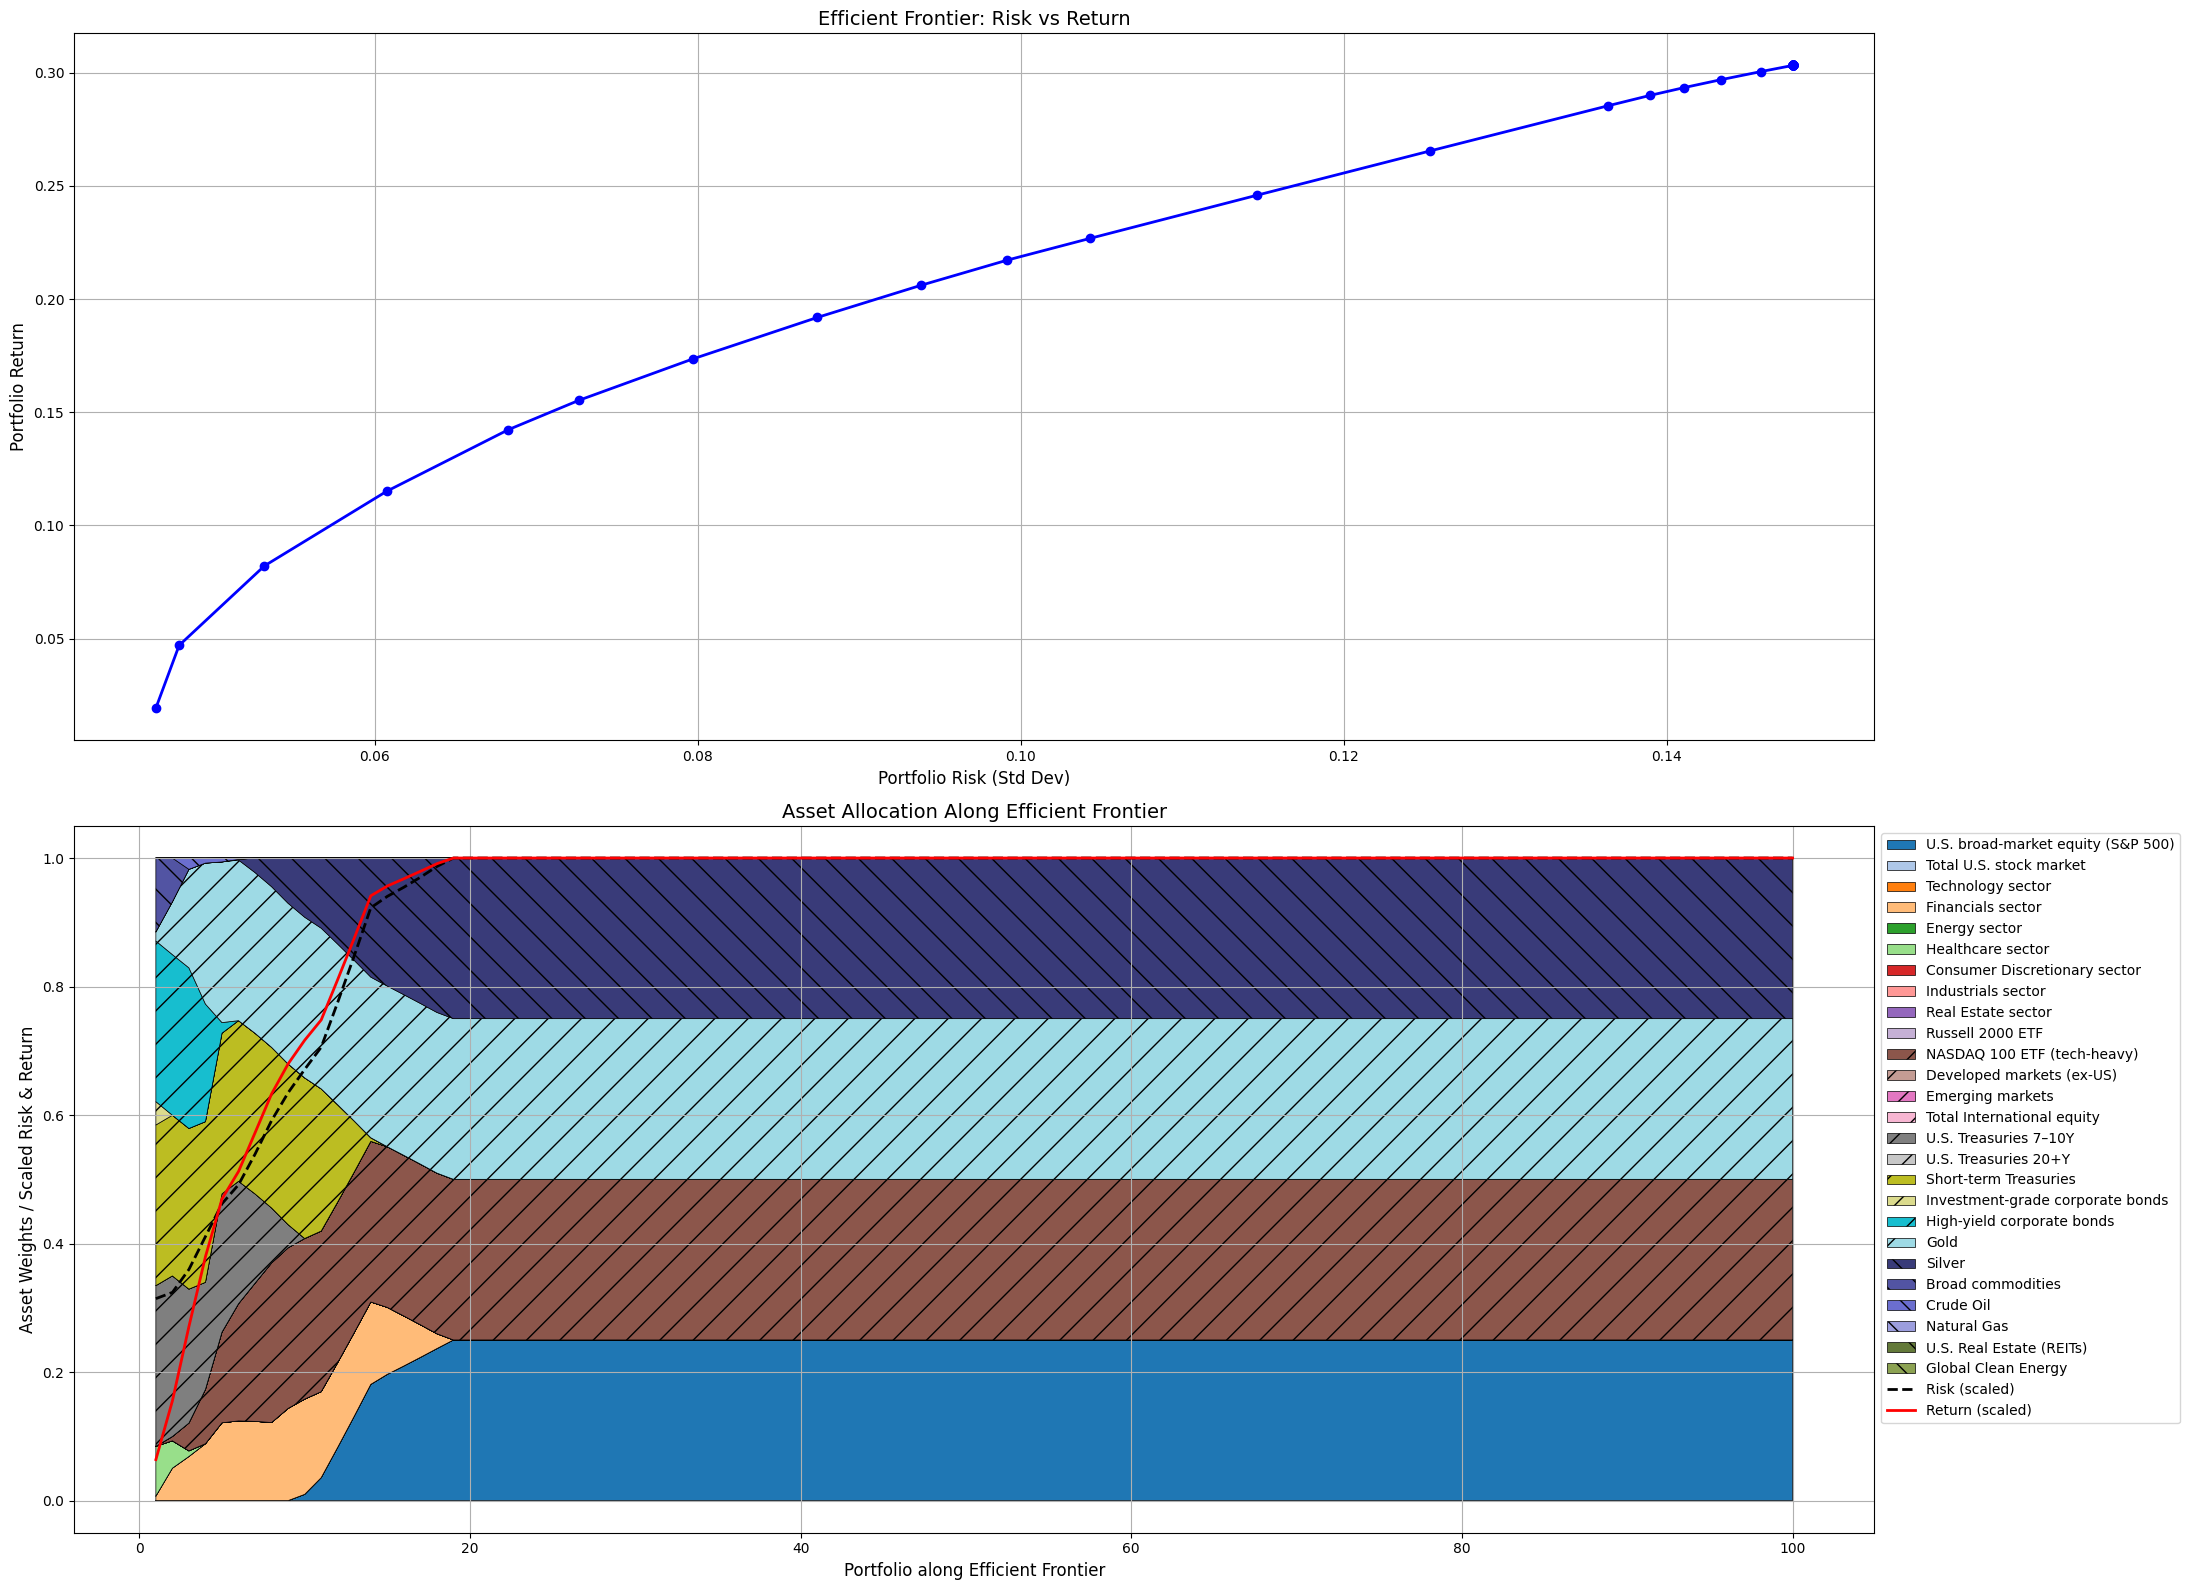

In [10]:
# Convert weights to DataFrame
weights_df = pd.DataFrame(weights_list, columns=list(tickers_dict.keys()))
portfolio_index = np.arange(len(frontier_risks)) + 1
num_assets = len(tickers_dict)

# Colors: first 20 solid, next 10 lighter
base_colors = plt.get_cmap('tab20').colors
extra_colors = plt.get_cmap('tab20b').colors
colors = list(base_colors) + list(extra_colors)
colors = colors[:num_assets]

# Hatches: first 20 none, rest diagonal '/'

if num_assets <= 10:
    hatches = [""]*num_assets
elif num_assets <= 20:
    hatches = [""]*10 + ["/"]*(num_assets-10)
else:
    hatches = [""]*10 + ["/"]*(10) + ["\\"]*(num_assets-20)

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(22, 16))

# Top plot: Efficient Frontier
axes[0].plot(frontier_risks, frontier_returns, marker='o', color='b', linewidth=2)
axes[0].set_xlabel("Portfolio Risk (Std Dev)", fontsize=12)
axes[0].set_ylabel("Portfolio Return", fontsize=12)
axes[0].set_title("Efficient Frontier: Risk vs Return", fontsize=14)
axes[0].grid(True)

# Bottom plot: Asset Weights along Frontier with hatches
bottom = np.zeros(len(portfolio_index))
for i, col in enumerate(weights_df.columns):
    axes[1].fill_between(portfolio_index,
                         bottom,
                         bottom + weights_df[col].values,
                         color=colors[i],
                         hatch=hatches[i],
                         edgecolor='k',
                         linewidth=0.5,
                         label=tickers_dict[col])
    bottom += weights_df[col].values

# Overlay scaled risk and return
axes[1].plot(portfolio_index, np.array(frontier_risks)/max(frontier_risks), color='k', linestyle='--', linewidth=2, label='Risk (scaled)')
axes[1].plot(portfolio_index, np.array(frontier_returns)/max(frontier_returns), color='r', linestyle='-', linewidth=2, label='Return (scaled)')

axes[1].set_xlabel("Portfolio along Efficient Frontier", fontsize=12)
axes[1].set_ylabel("Asset Weights / Scaled Risk & Return", fontsize=12)
axes[1].set_title("Asset Allocation Along Efficient Frontier", fontsize=14)
axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()
